In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('float_format', '{:f}'.format)

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df, dob = load_csv('glickoandprize')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)
df.dropna(inplace=True)
df = dobMerge(df, dob)
df.dropna(inplace=True)
df = df[(df.prizepool != 'Nan')]
df.prizepool = pd.to_numeric(df.prizepool)
df.prizeusd = pd.to_numeric(df.prizeusd.str.replace(r'\D', ''))

In [4]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

In [5]:
df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizepool.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizepool.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizepool.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizepool.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizepool.iloc[0]))

df['wdiffr'] = (df.prizepool.apply(np.log) / df.tiprize) * df.diffr

#cumulative sum of wdiffr
cumsums = df[['id', 'start', 'wdiffr']].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['id', 'start'])
df['cumuwr'] = cumsums
df = df.reset_index()
df['perf'] = df.cumuwr + df.init

In [6]:
ent = pd.DataFrame(df.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
df = ent.merge(df, on='id', how='left')

In [7]:
pd.set_option('float_format', '{:f}'.format)

In [8]:
df.head()

,entity,id,start,team,pos,tour,prizepool,place,prizeusd,startglicko2mu,...,exp,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,perf
0,0,mushi,2012-09-08,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,1609.568030,...,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,-1.214596,-1.214596,1445.816755
1,0,mushi,2012-10-22,orangeesports,2,G-1 Champions League Season 4,52879.200000,3,8012,1641.538726,...,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,47.650947,46.436351,1493.467703
2,0,mushi,2012-11-29,orangeesports,2,World Cyber Games 2012,33000.000000,4,0,1697.235587,...,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,-1.442597,44.993754,1492.025105
3,0,mushi,2014-05-24,dk,2,MarsTV Dota 2 League 2014,24046.500000,3-4,160310,1930.864266,...,21,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,7.779183,52.772936,1499.804288
4,0,mushi,2015-01-05,lvgaming,5,Dota 2 League Season 5,58397.000000,1,26679,1867.016147,...,29,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,-1.633441,51.139496,1498.170847


In [9]:
nt = df.groupby('id').size().reset_index()
df = df[df['id'].isin(nt[nt[0] >= 10].id.unique())]

In [10]:
df.head()

,entity,id,start,team,pos,tour,prizepool,place,prizeusd,startglicko2mu,...,exp,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,perf
0,0,mushi,2012-09-08,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,1609.568030,...,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,-1.214596,-1.214596,1445.816755
1,0,mushi,2012-10-22,orangeesports,2,G-1 Champions League Season 4,52879.200000,3,8012,1641.538726,...,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,47.650947,46.436351,1493.467703
2,0,mushi,2012-11-29,orangeesports,2,World Cyber Games 2012,33000.000000,4,0,1697.235587,...,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,-1.442597,44.993754,1492.025105
3,0,mushi,2014-05-24,dk,2,MarsTV Dota 2 League 2014,24046.500000,3-4,160310,1930.864266,...,21,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,7.779183,52.772936,1499.804288
4,0,mushi,2015-01-05,lvgaming,5,Dota 2 League Season 5,58397.000000,1,26679,1867.016147,...,29,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,-1.633441,51.139496,1498.170847


In [11]:
def panelOLSResult(df, Y, X):
    from linearmodels import PanelOLS 
    panel_data = df.set_index(['entity', 'start']).sort_index()
    panel_data['agesq'] = panel_data.age ** 2
    panel_data['const'] = 1
    panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
    Y = panel_data[Y]
    X = panel_data[X]
    mod = PanelOLS(Y, X, entity_effects=True)
    return mod.fit()

def feResult(res):
    fe = res.estimated_effects.reset_index().drop_duplicates().drop_duplicates(subset=['entity']).drop('time', 1)
    return ent.merge(fe, on='entity').sort_values('estimated_effects', ascending=False)

### Age and experience

In [12]:
from linearmodels import PanelOLS 
panel_data = df[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)

In [19]:
len(df.entity.unique())

164

In [13]:
panel_data.describe()

,perf,age,exp,pos,agesq,const,lexp
count,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000
mean,1773.630525,22.639532,26.041761,2.996091,518.791967,1.000000,3.041507
std,171.782185,2.498968,17.359077,1.415299,112.871091,0.000000,0.798491
min,1334.374897,15.739904,0.000000,1.000000,247.744583,1.000000,0.000000
25%,1654.939317,20.941821,12.000000,2.000000,438.559853,1.000000,2.564949
50%,1752.318285,22.696783,22.000000,3.000000,515.143960,1.000000,3.135494
75%,1878.260351,24.399726,37.000000,4.000000,595.346639,1.000000,3.637586
max,2275.313145,29.333333,83.000000,5.000000,860.444444,1.000000,4.430817


In [14]:
Y = panel_data['perf'].apply(np.log)
X = panel_data[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.2886
Estimator:,PanelOLS,R-squared (Between):,0.2345
No. Observations:,4861,R-squared (Within):,0.2886
Date:,"Sun, Mar 25 2018",R-squared (Overall):,0.2359
Time:,11:47:42,Log-likelihood,8116.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,634.87
Entities:,164,P-value,0.0000
Avg Obs:,29.640,Distribution:,"F(3,4694)"
Min Obs:,10.0000,,
Max Obs:,76.000,F-statistic (robust):,634.87


## $wrating = -2.6996*age^2+130.57*age+65.331*log(lexp)$
### $peakage: 24.18$

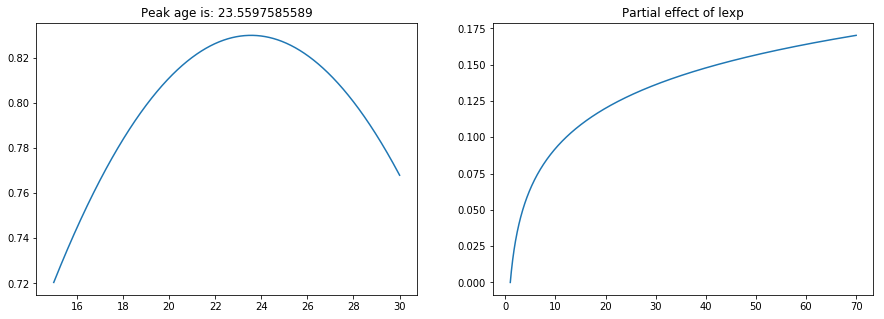

In [15]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()